Algorithm:
1. First send 100 pilots, whre each datapoint is a pilot, and get 100 channel values by least squares
2. Then train the VAR model on these 100 
3. Refit points contains the index of the 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json

# Parameters
packet_size = 100
pilot_size = 100
var_order = 25
mse_threshold = 0.1
noise_power = 0.1


In [14]:
# Load the complex channel values
with open("channels.txt", "r") as f:
    channel_vals = [json.loads(line)[0] for line in f]
channel_vals = np.array([complex(re, im) for re, im in channel_vals])

# Parameters
packet_size = 100
pilot_size = 100  # Full packet size for initial fit and refits
var_order = 25
mse_threshold = 0.1
noise_power = 0.1 # This is NSR in linear scale - set it to 0.1

def generate_random_bits(n):
    return np.random.choice([-1, 1], size=n)

def transmit_data(data, channel, noise_power):
    signal_power = np.mean((channel*data) ** 2)
    noise = np.sqrt(signal_power * noise_power/2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    return channel * data + noise

def estimate_channel(received, data):
    return np.linalg.lstsq(np.diag(data), received, rcond=None)[0]

def predict_channel_var(channel_history, steps):
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    model = VAR(channel_history_separated)
    results = model.fit(var_order, trend = "n")
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    return forecast[:, 0] + 1j * forecast[:, 1]


In [15]:
def generate_positive_definite_matrix(k):
    A = np.random.rand(k, k)
    A = np.dot(A, A.T)  # Make it symmetric and positive definite
    return A

def jakes_sos(P, K, Fs, Fd, N, typ='comp'):
    t = np.linspace(0, P/Fs, P)
    omega_d = 2 * np.pi * Fd
    
    # Initialize jakes_rvs to store real or complex numbers
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        alpha = np.random.uniform(0, 2 * np.pi, N)
        alpha_m = np.array([((2 * np.pi * n) - np.pi + al)/(4*N) for n, al in enumerate(alpha)])
        a_m = np.random.uniform(0, 2 * np.pi, N)
        b_m = np.random.uniform(0, 2 * np.pi, N)
        
        cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
        real_part = np.sqrt(1/N) * np.sum(cosine_terms, axis=1)
        
        if typ == 'comp':
            sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
            imag_part = np.sqrt(1/N) * np.sum(sine_terms, axis=1)
            jakes_rvs[k] = real_part + 1j * imag_part
        else:
            jakes_rvs[k] = real_part + 1j * 0
    
    return jakes_rvs

def generate_channels_for_doppler_frequencies(doppler_frequencies, sampling_frequency=100000, num_samples=100000):
    """
    Generate channel files for different Doppler frequencies
    """
    for Fd in doppler_frequencies:
        # Generate Jakes random variables
        jakes_rvs = jakes_sos(num_samples, 1, sampling_frequency, Fd, 100, 'comp')
        
        # Flatten the channel values
        channel_vals = jakes_rvs.flatten()
        
        # Create filename based on Doppler frequency
        filename = f"channel_Fd_{Fd}Hz.txt"
        
        # Write channels to file
        with open(filename, "w") as fo:
            for sample in channel_vals:
                # Write complex number as [real, imag]
                json.dump([sample.real, sample.imag], fo)
                fo.write('\n')
        print("Channel generated for:", Fd, "Hz")
                
def load_channel_values(filename):
    """
    Load channel values from a file
    """
    with open(filename, 'r') as fi:
        channel_vals = []
        for line in fi:
            # Parse JSON line as complex number
            real, imag = json.loads(line)
            channel_vals.append(complex(real, imag))
    return np.array(channel_vals)

def analyze_retransmission_frequency(doppler_frequencies, sampling_frequency=100000, mse_threshold = 0.1):
    retrans_frequencies = []
    for Fd in doppler_frequencies:
        # Load channel values for this Doppler frequency
        filename = f"channel_Fd_{Fd}Hz.txt"
        channel_vals = load_channel_values(filename)
        
        refit_counts = 0        
        # Initialize
        current_index = 0
        all_predictions = []
        actual_channels = []
        refit_points = []
        mse_values = []

        # Initial fit
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index+pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
        estimated_channel = estimate_channel(received_pilot, pilot_bits)
        all_predictions.extend(estimated_channel)
        actual_channels.extend(actual_channel)
        refit_points.append(current_index)
        current_index += pilot_size
        
        while current_index < len(channel_vals) - packet_size:
            data_bits = generate_random_bits(packet_size)
            actual_channel = channel_vals[current_index:current_index + packet_size]
            
            # Handle the case of first iteration or empty predictions
            if len(all_predictions) < pilot_size:
                predicted_channel = actual_channel[:packet_size]
            else:
                predicted_channel = predict_channel_var(all_predictions[-pilot_size:], packet_size)
            
            received_data = transmit_data(data_bits, actual_channel, noise_power)
            estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
            estimated_channel = estimate_channel(received_data, estimated_data_bits)
            
            mse = np.mean(np.abs(estimated_channel - actual_channel)**2)
            
            if mse > mse_threshold:
                refit_counts += 1
                pilot_bits = generate_random_bits(pilot_size)
                actual_channel = channel_vals[current_index:current_index + pilot_size]
                received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
                estimated_channel = estimate_channel(received_pilot, pilot_bits)
                all_predictions = np.concatenate([all_predictions, estimated_channel])
            else:
                all_predictions = np.concatenate([all_predictions, predicted_channel])
            
            current_index += packet_size
        
        retrans_frequencies.append(refit_counts / (len(channel_vals) / packet_size))
    
    return retrans_frequencies


In [16]:
print(channel_vals)

[-0.79226162+0.10648834j -0.79189101+0.10616942j -0.79152035+0.1058504j
 ... -0.24187318-0.39784613j -0.24178049-0.39785086j
 -0.24168774-0.39785545j]


In [17]:
refit_counts = 0        
# Initialize
current_index = 0
all_predictions = []
actual_channels = []
refit_points = []
mse_values = []

# Initial fit
pilot_bits = generate_random_bits(pilot_size)
actual_channel = channel_vals[current_index:current_index+pilot_size]
received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
estimated_channel = estimate_channel(received_pilot, pilot_bits)
all_predictions.extend(estimated_channel)
actual_channels.extend(actual_channel)
refit_points.append(current_index)
current_index += pilot_size

In [18]:
while current_index < len(channel_vals) - packet_size:
    # Generate random bits for data
    data_bits = generate_random_bits(packet_size)
    
    # Get actual channel values
    actual_channel = channel_vals[current_index:current_index+packet_size]
    actual_channels.extend(actual_channel)
    
    # Predict channel for entire packet
    predicted_channel = predict_channel_var(all_predictions[-pilot_size:], packet_size)
    
    # Transmit data
    received_data = transmit_data(data_bits, actual_channel, noise_power)
    
    # Estimate data bits using predicted channel
    #estimated_data_bits = np.sign(np.real(received_data / predicted_channel))
    estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate()/(abs(predicted_channel))**2))
    # Re-estimate channel using estimated data bits
    estimated_channel = estimate_channel(received_data, estimated_data_bits)
    
    # Calculate MSE
    mse = np.mean(np.abs(estimated_channel - actual_channel)**2)
    mse_values.append(mse)
    
    if mse > mse_threshold:
        # Refit using pilots
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index+pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
        estimated_channel = estimate_channel(received_pilot, pilot_bits)
        all_predictions.extend(estimated_channel)
        refit_points.append(current_index)
    else:
        # Use prediction
        all_predictions.extend(predicted_channel)
    
    current_index += packet_size

# # Plotting
# plt.figure(figsize=(12, 12))

# plt.subplot(3, 1, 1)
# plt.plot(np.real(actual_channels), label='Actual (Real)')
# plt.plot(np.real(all_predictions), label='Predicted (Real)')
# plt.scatter([r for r in refit_points], np.real([actual_channels[i] for i in refit_points]), 
#             color='red', marker='x', s=100, label='Refit Points')
# plt.title('Real Part of Channel')
# plt.legend()

# plt.subplot(3, 1, 2)
# plt.plot(np.imag(actual_channels), label='Actual (Imaginary)')
# plt.plot(np.imag(all_predictions), label='Predicted (Imaginary)')
# plt.scatter([r for r in refit_points], np.imag([actual_channels[i] for i in refit_points]), 
#             color='red', marker='x', s=100, label='Refit Points')
# plt.title('Imaginary Part of Channel')
# plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(mse_values)
# plt.title('Mean Squared Error')
# plt.axhline(y=mse_threshold, color='r', linestyle='--', label='MSE Threshold')
# plt.yscale('log')
# plt.legend()

# plt.tight_layout()
# plt.show()

# Calculate overall MSE
overall_mse = np.mean(np.abs(np.array(actual_channels) - np.array(all_predictions))**2)
#print(f"Overall MSE: {overall_mse}")
#print(len(refit_points * pilot_size)/len(channel_vals))
print(len(channel_vals)/len(refit_points))

222.71714922048997


Channel generated for: 1.0 Hz
Channel generated for: 14.121212121212121 Hz
Channel generated for: 27.242424242424242 Hz
Channel generated for: 40.36363636363636 Hz
Channel generated for: 53.484848484848484 Hz
Channel generated for: 66.60606060606061 Hz
Channel generated for: 79.72727272727272 Hz
Channel generated for: 92.84848484848484 Hz
Channel generated for: 105.96969696969697 Hz
Channel generated for: 119.0909090909091 Hz
Channel generated for: 132.21212121212122 Hz
Channel generated for: 145.33333333333334 Hz
Channel generated for: 158.45454545454544 Hz
Channel generated for: 171.57575757575756 Hz
Channel generated for: 184.6969696969697 Hz
Channel generated for: 197.8181818181818 Hz
Channel generated for: 210.93939393939394 Hz
Channel generated for: 224.06060606060606 Hz
Channel generated for: 237.1818181818182 Hz
Channel generated for: 250.3030303030303 Hz
Channel generated for: 263.42424242424244 Hz
Channel generated for: 276.54545454545456 Hz
Channel generated for: 289.6666666

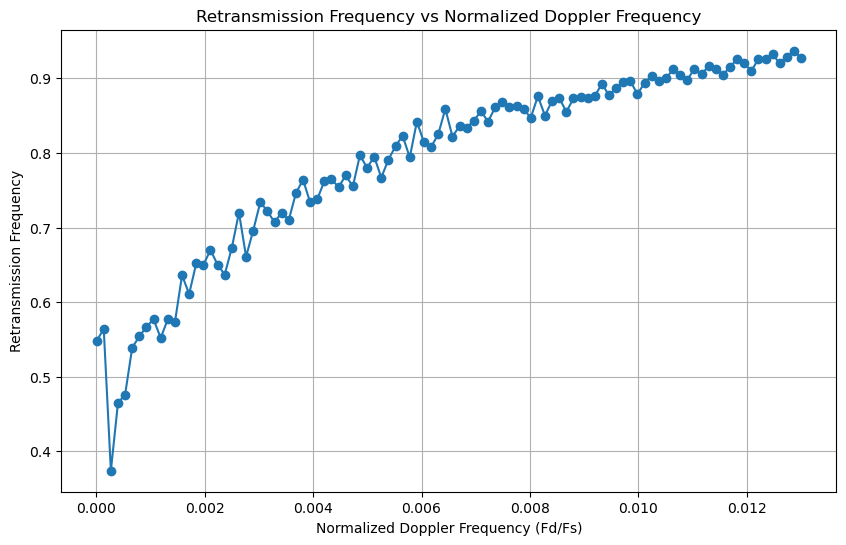

In [19]:
# Main execution
packet_size = 100
pilot_size = 100  # Full packet size for initial fit and refits
var_order = 25
mse_threshold = 0.1
noise_power = 0.1 # This is NSR in linear scale - set it to 0.1
sampling_frequency = 100000  # Sampling frequency in Hz
doppler_frequencies = np.linspace(0, 1700, 150)  # 10 Doppler frequencies between 100 and 700 Hz
def main():
    # Generate channel files for different Doppler frequencies
    generate_channels_for_doppler_frequencies(doppler_frequencies, sampling_frequency=100000, num_samples=100000)
    # Analyze retransmission frequencies
    retrans_frequencies = analyze_retransmission_frequency(doppler_frequencies)
    # Plot retransmission frequency vs normalized Doppler frequency
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_frequencies / sampling_frequency, retrans_frequencies, 'o-', label='Retransmission Frequency')
    plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
    plt.ylabel('Retransmission Frequency')
    plt.title('Retransmission Frequency vs Normalized Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

Channel generated for: 100 Hz
Channel generated for: 300 Hz
Channel generated for: 500 Hz
Channel generated for: 700 Hz


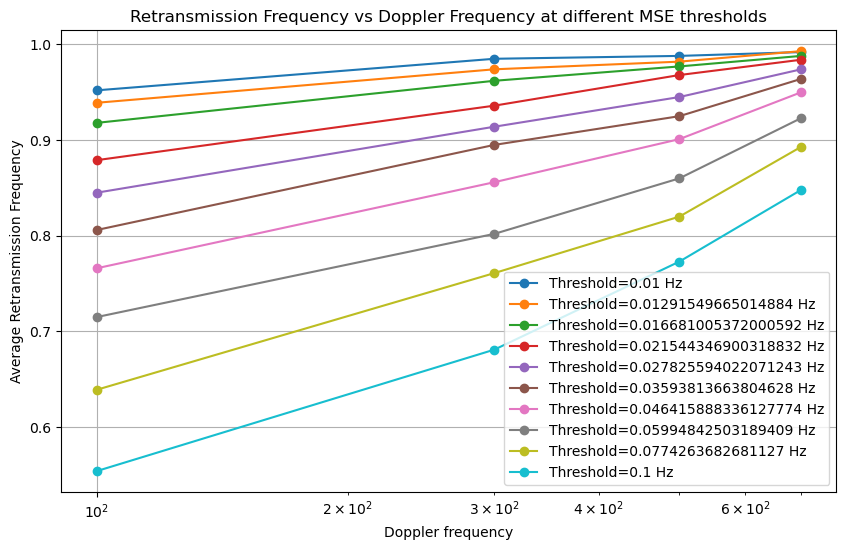

In [20]:
thresholds = np.logspace(-2, -1, 5)  # MSE thresholds
selected_dopplers = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
retrans_frequencies_dict = {thresh: [] for thresh in thresholds}
generate_channels_for_doppler_frequencies(selected_dopplers, sampling_frequency=100000, num_samples=100000)

for threshold in thresholds:
    retrans_frequencies_dict[threshold] = analyze_retransmission_frequency(selected_dopplers, sampling_frequency=100000, mse_threshold = threshold)
    
# Plot average retransmission frequency vs MSE threshold
plt.figure(figsize=(10, 6))
for thresh, avg_freqs in retrans_frequencies_dict.items():
    plt.semilogx(selected_dopplers, avg_freqs, 'o-', label=f'Threshold={thresh}')
plt.xlabel('Doppler frequency')
plt.ylabel('Average Retransmission Frequency')
plt.title('Retransmission Frequency vs Doppler Frequency at different MSE thresholds')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
def simulate_strategy_1(channel_vals, packet_size=100, pilot_size=100, mse_threshold=0.1, noise_power=0.1, var_order=25):
    """
    VAR strategy with MSE-based retraining
    
    Args:
    - channel_vals: Actual channel values
    - packet_size: Size of data packets
    - pilot_size: Size of initial training packets
    - mse_threshold: MSE threshold for retraining
    - noise_power: Noise power for transmission
    - var_order: Order of VAR model
    
    Returns:
    - Bit error rate (BER)
    """
    current_index = 0
    ber_count = 0
    total_bits = 0
    all_predictions = []
    retransmission_count = 0

    # Initial pilot transmission and VAR training
    pilot_bits = generate_random_bits(pilot_size)
    actual_channel = channel_vals[current_index:current_index+pilot_size]
    received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
    estimated_channel = estimate_channel(received_pilot, pilot_bits)
    all_predictions.extend(estimated_channel)
    current_index += pilot_size

    while current_index < len(channel_vals) - packet_size:
        # Generate data bits
        data_bits = generate_random_bits(packet_size)
        actual_channel = channel_vals[current_index:current_index + packet_size]

        # Predict channel
        if len(all_predictions) < pilot_size:
            predicted_channel = actual_channel[:packet_size]
        else:
            predicted_channel = predict_channel_var(
                np.array(all_predictions[-pilot_size:]), 
                packet_size
            )

        # Transmit data
        received_data = transmit_data(data_bits, actual_channel, noise_power)
        
        # Estimate bits using predicted channel
        estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
        
        # Compute bit errors
        bit_errors = np.sum(estimated_data_bits != data_bits)
        ber_count += bit_errors
        total_bits += packet_size

        # Compute MSE
        estimated_channel = estimate_channel(received_data, estimated_data_bits)
        mse = np.mean(np.abs(estimated_channel - actual_channel)**2)

        # Retransmit pilot if MSE exceeds threshold
        if mse > mse_threshold:
            retransmission_count += 1
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
            estimated_channel = estimate_channel(received_pilot, pilot_bits)
            all_predictions.extend(estimated_channel)
        else:
            all_predictions.extend(predicted_channel)

        current_index += packet_size

    return ber_count / total_bits

def simulate_strategy_2(channel_vals, packet_size=100, pilot_size=100, noise_power=0.1):
    """
    Fixed pilot transmission strategy
    
    Args:
    - channel_vals: Actual channel values
    - packet_size: Size of data packets
    - pilot_size: Size of pilot packets
    - noise_power: Noise power for transmission
    
    Returns:
    - Bit error rate (BER)
    """
    current_index = 0
    ber_count = 0
    total_bits = 0

    while current_index < len(channel_vals) - (packet_size + pilot_size):
        # Pilot transmission
        pilot_bits = generate_random_bits(pilot_size)
        actual_pilot_channel = channel_vals[current_index:current_index+pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_pilot_channel, noise_power)
        estimated_pilot_channel = estimate_channel(received_pilot, pilot_bits)

        # Data transmission
        current_index += pilot_size
        data_bits = generate_random_bits(packet_size)
        actual_data_channel = channel_vals[current_index:current_index + packet_size]
        received_data = transmit_data(data_bits, actual_data_channel, noise_power)

        # Estimate bits using pilot channel estimate
        estimated_data_bits = np.sign(np.real(received_data * estimated_pilot_channel.conjugate() / (abs(estimated_pilot_channel))**2))

        # Compute bit errors
        bit_errors = np.sum(estimated_data_bits != data_bits)
        ber_count += bit_errors
        total_bits += packet_size

        current_index += packet_size

    return ber_count / total_bits

def main():
    # Load channel values
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])

    # Simulation parameters
    snr_values = np.linspace(-5, 15, 20)  # SNR values in dB
    mse_thresholds = [0.1]  # Different MSE thresholds

    plt.figure(figsize=(15, 10))

    # Simulate and plot for different MSE thresholds
    for mse_threshold in mse_thresholds:
        ber_strategy1 = []
        ber_strategy2 = []

        # Simulate for different SNR values
        for snr_db in snr_values:
            noise_power = 10**(-snr_db / 10)
            
            # Simulate both strategies with current MSE threshold
            ber1 = simulate_strategy_1(channel_vals, mse_threshold=mse_threshold, noise_power=noise_power)
            ber2 = simulate_strategy_2(channel_vals, noise_power=noise_power)
            
            ber_strategy1.append(ber1)
            ber_strategy2.append(ber2)

        # Plot results for this MSE threshold
        plt.semilogy(snr_values, ber_strategy1, 'o-', label=f'Adaptive VAR (MSE Threshold: {mse_threshold})')
        plt.semilogy(snr_values, ber_strategy2, 'x-', label=f'Fixed Pilot (MSE Threshold: {mse_threshold})')

    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (Log Scale)')
    plt.title('Bit Error Rate vs SNR for Different MSE Thresholds')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

C:\Users\vigne\AppData\Local\Temp\ipykernel_24712\4282410479.py:48: RuntimeWarning: overflow encountered in square
  estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
C:\Users\vigne\AppData\Local\Temp\ipykernel_24712\4282410479.py:48: RuntimeWarning: overflow encountered in square
  estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
C:\Users\vigne\AppData\Local\Temp\ipykernel_24712\4282410479.py:48: RuntimeWarning: overflow encountered in square
  estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
C:\Users\vigne\AppData\Local\Temp\ipykernel_24712\4282410479.py:48: RuntimeWarning: overflow encountered in square
  estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
C:\Users\vigne\AppData\Local\Temp\ipykernel_24712\4282410479.py:48: 

LinAlgError: SVD did not converge in Linear Least Squares

<Figure size 1500x1000 with 0 Axes>